# Building models for predicting default credits 

Home Credit is known for making offers for people without credit history. Based on this assumption we will try to build three models for different types of applications for people with and without credit history.
The objective of this notebook is to build models which would most accurately predict defaulters based on:
* data from application_train only
* data from application_train and historical data from Credit Bureau and Home Credit


We will compare which of the above is the best for both clients who want to take credit and Home Credit which will earn more in the process.

## Libraries and functions

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import random
import matplotlib.ticker as ticker
from typing import List
from sklearn.pipeline import Pipeline
from feature_engine.selection import RecursiveFeatureElimination
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import roc_curve
import pickle
import shap
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.width = None
pd.options.display.max_colwidth = None
pd.options.display.float_format = "{:,.2f}".format

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
import matplotlib.pyplot as plt

In [2]:
# ======================= Getting data =======================
def reduce_memory_usage(df: DataFrame) -> DataFrame:
    """Reduced memory usage by downcasting datatype of columns.
    Input: DataFrame
    Output: DataFrame"""

    # Downcasting dataframe
    for column in df:
        if df[column].dtype in ["float64", "float32"]:
            df[column] = pd.to_numeric(df[column], downcast="float")
        if df[column].dtype in ["int64", "int32"]:
            df[column] = pd.to_numeric(df[column], downcast="integer")
    return df


def load_data(name: str) -> DataFrame:
    """Loads DataFrame from csv and reduces used memory.
    Parameters: name (the name of csv file without .csv extension)
    Returns: DataFrame"""

    print("-" * 100)
    print(f"{name}.csv loading")
    df = pd.read_csv(f"{name}.csv")
    memory = df.memory_usage().sum() / 1024**2
    df = reduce_memory_usage(df)
    print(
        f"memory usage reduced from {memory:.1f}MB to {(df.memory_usage().sum() / 1024**2):.1f}MB"
    )
    print("-" * 100)
    return df


def pie_plot(df: DataFrame, col_name: str, labels: List) -> None:
    """Plots a pie chart of distribution of chosen column."""
    
    # Data to plot
    plot_data = df[col_name].value_counts() / df.shape[0]
    
    # Pie plot
    plt.title(f"Pie chart of {col_name} variable")
    plt.pie(plot_data, labels=labels, labeldistance=1.15, 
            wedgeprops= { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')

def compare_models(models, X: pd.DataFrame, y: pd.Series) -> None:
    """Compares different models using cross-validation and plots the results.

    Parameters: models (list of models), X (input features), y (target variable)
    Returns: None
    """

    # Initializing lists with scores
    mean_scores = []
    std_scores = []
    model_names = [model.__class__.__name__ for model in models]
    skf = StratifiedKFold(n_splits=5)

    # Scoring models
    for model in models:
        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=skf)
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))
        
        print(f'[{model}: {round(np.mean(scores), 3)}')
    
    # Plotting output
    x_ticks = np.arange(len(model_names))
    plt.bar(x_ticks, mean_scores, yerr=std_scores, align='center', alpha=0.7, capsize=10)
    plt.xticks(x_ticks, model_names, rotation=45)
    plt.ylabel('Mean Cross-Validation ROC_AUC Score')
    plt.title('Comparison of Model Performance')
    plt.tight_layout()
    plt.show()

## Models based on data from application_train.csv only

### Loading data

In [6]:
application = reduce_memory_usage(pd.read_csv('preprocessed_data/selected_application', index_col='Unnamed: 0'))
application.head(2)

,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_Pensioner,NAME_FAMILY_STATUS_Married,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_XNA,ORGANIZATION_TYPE_Business,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_XNA,HOUSETYPE_MODE_block_of_flats,HOUSETYPE_MODE_XNA,WALLSMATERIAL_MODE_XNA,WALLSMATERIAL_MODE_Panel,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_XNA,RATIO_ANNUITY_TO_INCOME,REGION_TO_INCOME,RATIO_INCOME_TO_EXT_SOURCE,RATIO_CREDIT_TO_EXT_SOURCE,SUM_EXT_SOURCES,MEAN_EXT_SOURCES,MAX_EXTERNAL_SOURCES,MIN_EXT_SOURCES,PROD_EXT_SOURCES,WEIGHTED_EXT_SOURCES,CREDIT_ANNUITY_RATIO,PROD_REGION_POPULATION_AMT_CREDIT,PROD_REGION_RATING_AMT_INCOME,INCOME_PER_CHILD,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,MEAN_50_NN,MEAN_100_NN,SK_ID_CURR,TARGET
0,0.00,"202,500.00","406,597.50","24,700.50","351,000.00",1,0.02,9461,637.00,9.00,1,1,2,2,2,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.00,0.07,0.08,0.12,0.04,0.02,0.00,0.03,0.04,0.97,0.63,0.00,0.07,0.08,0.04,0.02,0.02,0.00,0.03,0.04,0.97,0.62,0.00,0.07,0.08,0.04,0.02,0.00,0.01,2.00,"1,134.00",1,1.00,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0.12,"405,000.00","1,442,556.58","2,896,493.34",0.49,0.16,0.26,0.08,0.00,1.51,16.46,"7,644.44","405,000.00","202,500,000.00","202,297.70",0.12,0.06,0.12,0.12,100002,1
1,1.00,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",3,0.00,16765,"1,188.00",9.00,1,1,1,1,2,0,0,0,0.31,0.62,0.54,0.10,0.05,0.99,0.80,0.08,0.03,0.29,0.33,0.01,0.05,0.01,0.09,0.05,0.99,0.80,0.08,0.03,0.29,0.01,0.08,0.06,0.00,0.10,0.05,0.99,0.80,0.08,0.03,0.29,0.01,0.06,0.01,0.07,0.00,828.00,1,0.00,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0.13,"270,000.00","503,471.87","2,412,007.88",1.47,0.49,0.62,0.31,0.10,4.63,36.23,"4,580.29","270,000.00","270,000,000.00","134,932.53",0.13,0.03,0.04,0.04,100003,0


### Splitting data 

In the previous section we used specific SK_ID_CURR for training and test set with split 3:2 to minimize the time consumed on preprocessing. Here we will use stored SK_ID_CURR from the file test_sk_id_curr.txt to perform the split. 

In [7]:
# Read in SK_ID_CURR of test and validation set 
with open('test_sk_id_curr.txt', 'r') as f:
    test_val_ids = []
    for line in f:
        sk_id_curr = int(line.strip())
        test_val_ids.append(sk_id_curr)

# SK_ID_CURR of test set - randomly selected half of the list
test_ids = random.sample(test_val_ids, len(test_val_ids)//2)

# Splitting for train and test set
application_train = application.loc[~application['SK_ID_CURR'].isin(test_ids)]
application_test = application.loc[application['SK_ID_CURR'].isin(test_ids)]

In [35]:
application_train.shape, application_test.shape

((235518, 93), (71993, 93))

### Plotting TARGET distribution

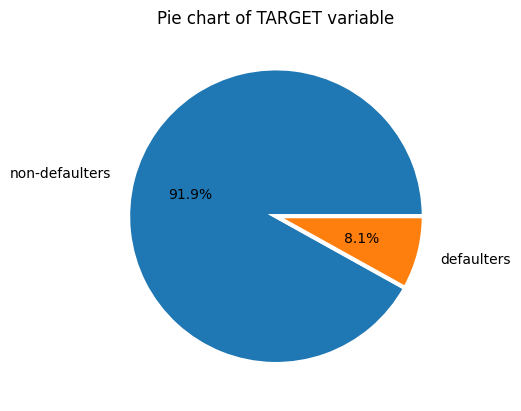

In [6]:
pie_plot(application, 'TARGET', ['non-defaulters', 'defaulters'])

The classes of target variable are imbalanced. We will use hyperparameter from the algorithms to put more weight on minority class. 

### Comparison of model performance 

[SVC(class_weight='balanced'): 0.755
[LogisticRegression(class_weight='balanced'): 0.767
[RandomForestClassifier(class_weight='balanced', random_state=42): 0.746
[XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              predictor=None, random_state=None, ...): 0.761
[LGBMClassifier(class_weight='balanced', force_row_wise=True, n_jobs=4,
         

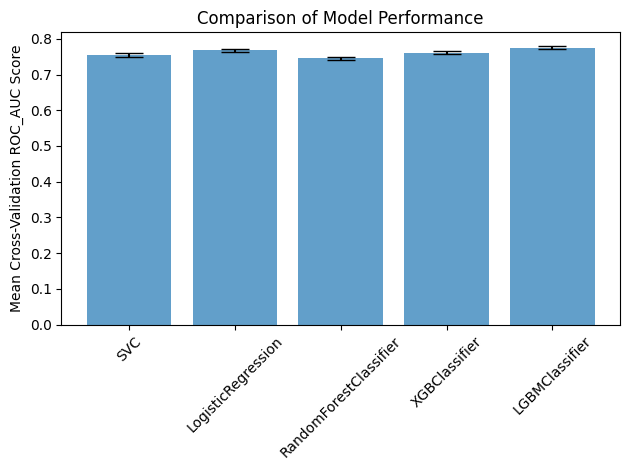

In [7]:
# Splitting data 
X = application_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = application_train['TARGET']

# Calculate scale_pos_weight
scale_pos_weight = (y == 0 ).sum() / (y == 1).sum()

# Models to compare
models = [
        SVC(class_weight='balanced'), 
        LogisticRegression(class_weight='balanced'),
        RandomForestClassifier(class_weight='balanced', random_state=42),
        XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=4),
        LGBMClassifier(class_weight='balanced', force_row_wise=True, n_jobs=4, verbose=-1)
         ]

# Calling comparison function
compare_models(models, X, y)

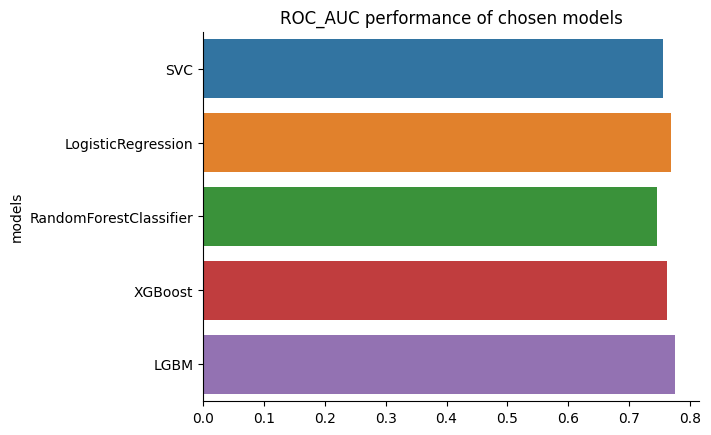

In [8]:
models_scores = pd.DataFrame({'models': ['SVC', 'LogisticRegression', 'RandomForestClassifier', 'XGBoost', 'LGBM'],
             'roc_auc': [0.755, 0.768, 0.746, 0.762, 0.776]})
sns.barplot(data=models_scores, x='roc_auc', y='models')
plt.title('ROC_AUC performance of chosen models')
plt.xlabel('')
sns.despine()

## Models with merged data from all datasets

In this section we will perform following opperation:
* merging data from all sources
* splitting into training and testing
* recursively remove features which don't add value to LGBMClassifier
* compare models based on the method of imputation of missing values: filling with zeros and filling using KNNImputer
(https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py - based on the source the KNNImputer gives highier scores)
* comparing models with chosen method of imputation
* getting two best performing models and tuning them
* fitting and interpreting best performing model

### Merging data from Credit Bureau, HomeCredit with application_train

In [36]:
# Reading in all preprocessed datasets
bureau = reduce_memory_usage(pd.read_csv('preprocessed_data/selected_bureau.csv', index_col=0))
pos_cash = reduce_memory_usage(pd.read_csv('preprocessed_data/selected_pos_cash.csv', index_col=0))
installments = reduce_memory_usage(pd.read_csv('preprocessed_data/selected_installments_payments.csv', index_col=0))
previous = reduce_memory_usage(pd.read_csv('preprocessed_data/selected_previous_application.csv', index_col=0))
ccb = reduce_memory_usage(pd.read_csv('preprocessed_data/credit_card_balance_selected.csv', index_col=0))

# Merging  with application_train
df_merged = application.merge(bureau, on='SK_ID_CURR', how='left')
df_merged = df_merged.merge(pos_cash, on='SK_ID_CURR', how='left')
df_merged = df_merged.merge(installments, on='SK_ID_CURR', how='left')
df_merged = df_merged.merge(previous, on='SK_ID_CURR', how='left')
df_merged = df_merged.merge(ccb, on='SK_ID_CURR', how='left')

print(f'Shape of merged dataframe: {df_merged.shape}')

Shape of merged dataframe: (307511, 226)


### Splitting data 

In [37]:
# Separating into training and testing set
df_train = df_merged.loc[~df_merged['SK_ID_CURR'].isin(test_ids)]
df_test = df_merged.loc[df_merged['SK_ID_CURR'].isin(test_ids)]

# Getting X_train and y_train
X_train = df_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train = df_train['TARGET']

### Recursive removal of not important features

Running the following code:
```python
skf = StratifiedKFold(n_splits=5, shuffle=True)
rfe = RecursiveFeatureElimination(LGBMClassifier(class_weight='balanced', force_row_wise=True, n_jobs=4, verbose=-1), cv=skf)
rfe.fit(X_train, y_train)
```
We were able to get the preformance drifts. The sorted list of tuples with name of features and their performnace drifts in the next cell. By removing them the dimensionality of dataframe will be reduced.

In [11]:
 performance_drifts = [
 ('NAME_CONTRACT_TYPE_CASH_LOANS_SUM', -0.00034482319745055),
 ('PREVIOUS_CREDIT_CARD_COUNT', -0.00034581762428542717),
 ('RATIO_INCOME_TO_EXT_SOURCE', -0.0003464185630972505),
 ('WALLSMATERIAL_MODE_Panel', -0.0003579147013663686),
 ('WEIGHTED_EXT_SOURCES', -0.0003596963594852953),
 ('NAME_SELLER_INDUSTRY_XNA_SUM', -0.00036037420607060167),
 ('FRESH_STATUS_FIRST_MAX_ACTIVE', -0.00036321399921479536),
 ('REGION_RATING_CLIENT_W_CITY', -0.000366971696051821),
 ('ENTRANCES_MEDI', -0.00036877982694505373),
 ('OLD_CNT_DRAWINGS_CURRENT_SUM', -0.0003765820813653731),
 ('OLD_DIFF_DAYS_PAYMNET_MAX', -0.00038533942875706995),
 ('ORGANIZATION_TYPE_Business', -0.00038723907103888067),
 ('OCCUPATION_TYPE_XNA', -0.00040971790842525557),
 ('FRESH_AMT_CREDIT_LIMIT_ACTUAL_MAX', -0.000411042006632778),
 ('OLD_AMT_PAYMENT_TOTAL_CURRENT_MAX', -0.0004461383131597607),
 ('OLD_NUM_INSTALMENT_VERSION_MAX', -0.0004466458594001299),
 ('OLD_DAYS_ENTRY_PAYMENT_MEAN', -0.00045156873301643863),
 ('WALLSMATERIAL_MODE_XNA', -0.00045998296923421833),
 ('ELEVATORS_MEDI', -0.0004911722461286017),
 ('FLAG_LAST_APPL_PER_CONTRACT_Y_SUM', -0.0005167980619168455),
 ('ENTRANCES_AVG', -0.0005214554426440365),
 ('OLD_CNT_DRAWINGS_ATM_CURRENT_MAX', -0.0005225184559448648),
 ('EXT_SOURCE_3', -0.0005306295509865944),
 ('BASEMENTAREA_AVG', -0.00055651492722264),
 ('OLD_AMT_DRAWING_ALL_SUM', -0.0005602593240869869),
 ('NONLIVINGAREA_MEDI', -0.0005925435807020429),
 ('MEAN_100_NN', -0.0005964009116248281),
 ('FLAG_PHONE', -0.0006062165548914589),
 ('MEAN_EXT_SOURCES', -0.0006173136283971203),
 ('NONLIVINGAREA_MODE', -0.000619029927664605),
 ('ORGANIZATION_TYPE_XNA', -0.0006264756272628125),
 ('NAME_PAYMENT_TYPE_XNA_SUM', -0.0006338193497019695),
 ('OLD_MONTHS_BALANCE_MEAN', -0.0006395141966636375),
 ('NONLIVINGAREA_AVG', -0.00064109400910628),
 ('OLD_AMT_PAYMENT_CURRENT_MEAN', -0.0006649158941933742),
 ('NAME_YIELD_GROUP_HIGH_SUM', -0.000691920745270469),
 ('YEARS_BEGINEXPLUATATION_MEDI', -0.0006958923102631243),
 ('OLD_CNT_INSTALMENT_MATURE_CUM_MIN', -0.0007395474143578884),
 ('NAME_INCOME_TYPE_Working', -0.0007784388222562555),
 ('OLD_NUM_INSTALMENT_VERSION_MEAN', -0.0008183396909735574),
 ('NAME_SELLER_INDUSTRY_CONNECTIVITY_SUM', -0.0008513708938326925),
 ('FRESH_SK_DPD_SUM', -0.0008797344305921939),
 ('ANNUITY_INCOME_PERC', -0.0009317765316502191),
 ('FRESH_CNT_DRAWINGS_CURRENT_SUM', -0.0010388805605913154),
 ('OLD_RATIO_AMT_PAYMENT_MIN', -0.0012131578199559012)]

In [12]:
# Removing columns with performance drift lower than -0.003
columns_to_remove = [col[0] for col in performance_drifts]
X_removed = X_train.drop(columns_to_remove, axis=1)

In [13]:
print(f'The shape of dataframe after reduction: {X_removed.shape}')

The shape of dataframe after reduction: (235518, 179)


## Comparison of filling missing values with 0 and mean values of 5 nearest neighbours

### Filling in missing values with 0

In [14]:
# Filling in with 0
X_train_zeroes = X_removed.fillna(0)

# Checking the results for LGBMClassifier
skf = StratifiedKFold(n_splits=5)
lgbm = LGBMClassifier(class_weight='balanced', force_row_wise=True, n_jobs=4, verbose=-1)
results = cross_val_score(lgbm, X_train_zeroes, y_train, scoring='roc_auc', cv=skf)
print(f'ROC_AUC for LGBMClassifier with NaN values filled with 0: {round(np.mean(results), 3)}')

ROC_AUC for LGBMClassifier with NaN values filled with 0: 0.787


### Imputing with the mean values of 5 nearest neighbours

Running the following code:

```python
from sklearn.impute import  KNNImputer

# Fitting on complete data KNNImputer
imputer = KNNImputer(missing_values=np.nan).fit(X_removed.dropna())
# Transforming the training set
X_train_nn = imputer.transform(X_removed)

# Scoring model
skf = StratifiedKFold(n_splits=5, shuffle=True)
lgbm = LGBMClassifier(class_weight='balanced', force_row_wise=True, n_jobs=4, verbose=-1)
results = cross_val_score(lgbm, X_train_nn, y_train, scoring='roc_auc', cv=skf)
round(np.mean(results))
```
We got the **ROC_AUC** mean score  equal **0.786**. The score is comparable to filling missing values with 0 but is computational heavy which could actually cause additional problems with deployment.

## Comparing model performance on merged data

[SVC(class_weight='balanced'): 0.759
[LogisticRegression(class_weight='balanced'): 0.776
[RandomForestClassifier(class_weight='balanced', random_state=42): 0.753
[XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              predictor=None, random_state=None, ...): 0.769
[LGBMClassifier(class_weight='balanced', force_row_wise=True, n_jobs=4,
         

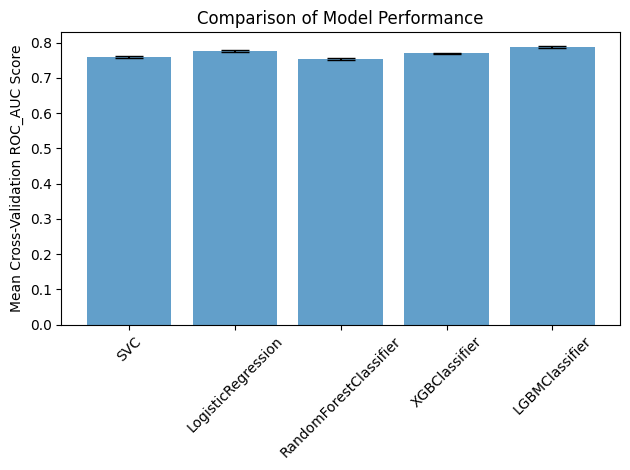

In [15]:
# Calling comparison function
compare_models(models, X_train_zeroes, y_train)

## Parameter tuning of LGBMClassifier and XGBClassifier

In [16]:
space = hp.choice('classifiers', [
        {
    'model': XGBClassifier(eval_metric='auc', scale_pod_weight=scale_pos_weight, verbosity=0, seed=100),
    'params': {
        'model__max_depth' : hp.choice("xgb.max_depth", range(3, 18, 1)),
        'model__gamma': hp.uniform ('xgb.gamma', 1,9),
        'model__learning_rate' : hp.quniform('xgb.learning_rate',
                                             0.01, 0.5, 0.01),
        'model__n_estimators' : hp.choice('xgb.n_estimators',
                                          range(5, 200, 1)),
        'model__reg_lambda' : hp.uniform ('xgb.reg_lambda', 0,1),
        'model__reg_alpha' : hp.quniform('xgb.reg_alpha', 40,180,1),
        'model__colsample_bytree' : hp.uniform('xgb.colsample_bytree', 0.5,1),
        'model__min_child_weight' : hp.quniform('xgb.min_child_weight', 0, 10, 1),

    }
    },
        {
    'model': LGBMClassifier(eval_metric='auc', scale_pod_weight=scale_pos_weight, verbosity=-1, random_state=42),
    'params': {
        'model__max_depth' : hp.choice("lgbm.max_depth", range(3, 12)),
        'model__num_leaves': hp.choice('lgbm.num_leaves', range(20, 3000)),
        'model__learning_rate' : hp.quniform('lgbm.learning_rate',
                                             0.01, 0.3, 0.01),
        'model__mean_data_in_leaf' : hp.choice('lgbm.n_mean_data_in_leaf',
                                          range(100, 1000, 100)),
        'model__n_estimators' : hp.choice('lgbm.n_estimators', range(50, 5000, 50)),
        'model__lambda_l1' : hp.choice('lgbm.lambda_l1', range(0,100, 5)),
        'model__min_gain_to_split' : hp.choice('lgbm.min_gain_to_split', range(0, 15))

    
    }
    },
    
])

In [17]:
def objective(args):
    
    # Initialize model pipeline
    pipe =  Pipeline(steps=[
    # modeling
    ('model', args['model'])
    ])
    
    pipe.set_params(**args['params']) # Model parameters will be set here
    
    # Cross Validation Score. Note the transformer.fit_transform for X_train. 

    
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    results = cross_val_score(pipe, X_train_zeroes, y_train, scoring='roc_auc', cv=skf)
    
    print(f"Model Name: {args['model']}: ", results)
          
    # Since we have to minimize the score, we return 1- score.
    return {'loss': 1 - np.mean(results), 'status': STATUS_OK}

In [18]:
# Initialising hyperopt trails
trials = Trials()

# Fmin will call the objective function with selective param set. 
# The choice of algorithm will narrow the searchspace.
best_classifier = fmin(objective, space, algo=tpe.suggest,
                       max_evals=40, trials=trials, verbose=0)

Model Name: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7071913903173512, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.9650759287660335, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.42, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1.0, missing=nan,
              monotone_constraints=None, n_estimators=58, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...):  [0.78352431 0.78737288 0.7830944  0.79368491 0.78354618]
Model Name: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsa

In [19]:
# Getting the best classifier from the search space 
best_params = space_eval(space, best_classifier)


model = best_params['model']
hyperparameters = best_params['params']

for param_name, param_value in hyperparameters.items():
    # Removing model__ prefix from names
    param_name = param_name.replace('model__', '')

    # Setting hyperparameter value
    setattr(model, param_name, param_value)
        
model                                  

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7705181863377738, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=4.440264908131182, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=3.0, missing=nan,
              monotone_constraints=None, n_estimators=167, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [20]:
results = cross_val_score(model, X_train_zeroes, y_train, scoring='roc_auc', cv=skf)
print(f"The results for tunned model: ", results)

The results for tunned model:  [0.78623196 0.79026825 0.78693451 0.7912608  0.7912577 ]


The mean roc_auc value for best performing model is 0.789. Now let's train the model and evaluate on the test set. 

## Training the best performing model

In [40]:
# Getting testing sets
X_test = df_test.drop((columns_to_remove + ['SK_ID_CURR', 'TARGET']), axis=1).fillna(0)
y_test = df_test['TARGET']

In [27]:
# Training the model
model.fit(X_train_zeroes, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7705181863377738, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=4.440264908131182, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=3.0, missing=nan,
              monotone_constraints=None, n_estimators=167, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

Hyperparameters of best preforming XGBClassifier: 
* colsample_bytree=0.7705181863377738, 
* gamma=4.440264908131182, 
* learning_rate=0.12,  
* max_depth=10,
* min_child_weight=3.0,
* n_estimators=167, 
* n_jobs=4, 
* scale_pod_weight=11.7, 
* verbosity=0, 
* seed=100

In [44]:
# Getting probabilities of predictions
y_pred = model.predict_proba(X_test)[:, 1]
print(f'ROC_AUC of the test set: {round(roc_auc_score(y_test, y_pred), 3)}')

ROC_AUC of the test set: 0.78


## Saving the model

In [48]:
joblib.dump(model, 'model.joblib')

## Interpretation of the most important features

### Feature importance 

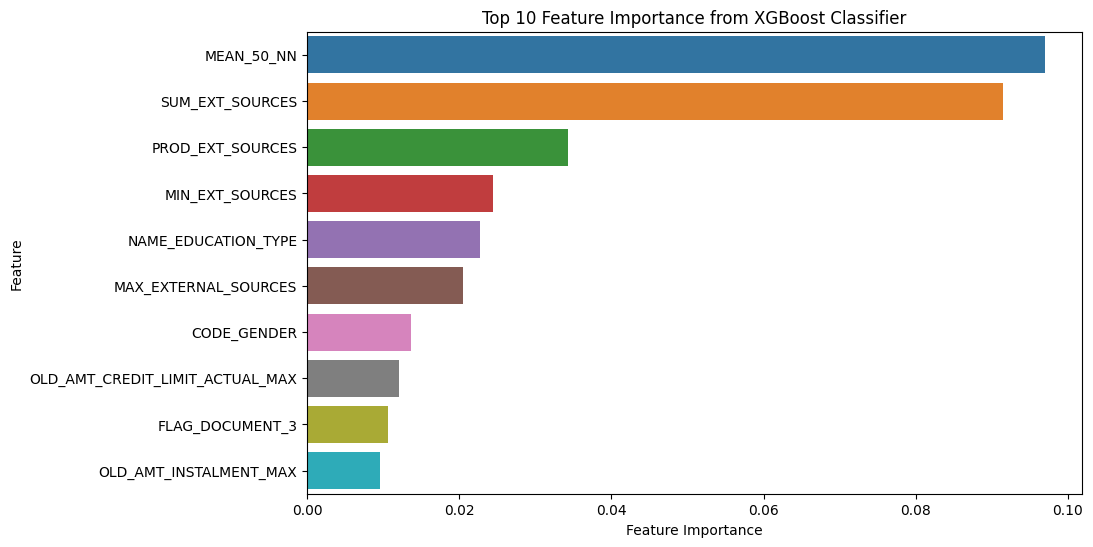

In [59]:
# Get feature importance scores
importance_scores = model.feature_importances_

# Get feature names
feature_names = X_test.columns

# Create a DataFrame for easier manipulation
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
top_features = importance_df.nlargest(10, 'Importance')  # Select the top 10 features

# Plot the top feature importance using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance from XGBoost Classifier')
plt.show()

There are 2 most important features are mean value of target for 50 nearest neighbours and as well as math operations on external sources. Other features that play a role are: education type, gender, as well as data for older credits.  

### Impact of features on predictions

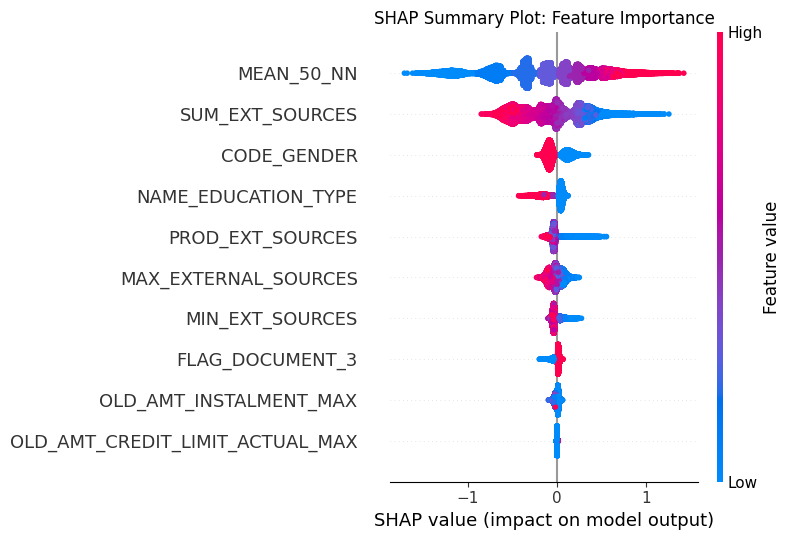

In [88]:
# Sort features based on importance scores
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_features = feature_names[sorted_indices]

# Calculate SHAP values for the sorted features
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot using seaborn
shap.summary_plot(shap_values[:, sorted_indices[:10]], X_test.iloc[:, sorted_indices[:10]], show=False)

# Castomizing the plot
plt.title("SHAP Summary Plot: Feature Importance")
plt.tight_layout()  # Ensures proper spacing
plt.savefig('summary_plot_with_title.png', dpi=300, bbox_inches='tight')
plt.show()

Features that contibute defaulting:
* highier values of mean target for 50 nearest neighbours
* lower values of sum from external sources
* lower minimum values of diffence in expected and actual payments for credits from last 2 years
* being male
* highier values of ratio of credit amount to external source 3
* lower number of days of employment
* lower education score
* delivered document 3

Most important features: 'MEAN_50_NN', 'MEAN_100_NN', 'SUM_EXT_SOURCE', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'PROD_EXT_SOURCES', 'MAX_EXT_SOURCES', 'MIN_EXT_SOURCES', 'FLAG_DOCUMENT_3', 'OLD_AMT_INSTALMENT_MAX', 'OLD_AMT_CREDIT_LIMIT_ACTUAL_MAX'

## Calculating optimal threshold

The tuning of threshold will be performed on predictions from whole dataset.

In [155]:
# Getting X from full dataframe
df_full = df_merged.drop(columns_to_remove, axis=1).fillna(0)
X = df_full.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df_full['TARGET']

y_pred = model.predict_proba(X)[:, 1]

### From roc_curve

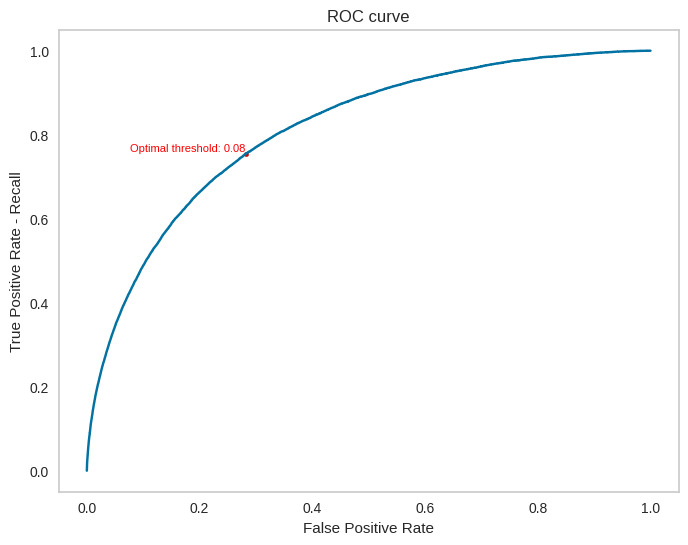

In [156]:
# Create the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred)

# Calculating optimal threshold
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
optimal_threshold = round(thresholds[index], ndigits = 4)
optimal_fpr = round(fpr[index], ndigits = 4)
optimal_tpr = round(tpr[index], ndigits = 4)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.scatter(optimal_fpr, optimal_tpr, c='r', s=10)
plt.grid(visible=False)
plt.text(optimal_fpr, optimal_tpr, 
         f'Optimal threshold: {optimal_threshold:.2f}', color='red', fontsize=8,
         verticalalignment='bottom', horizontalalignment='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate - Recall');

### From precision_recall_curve

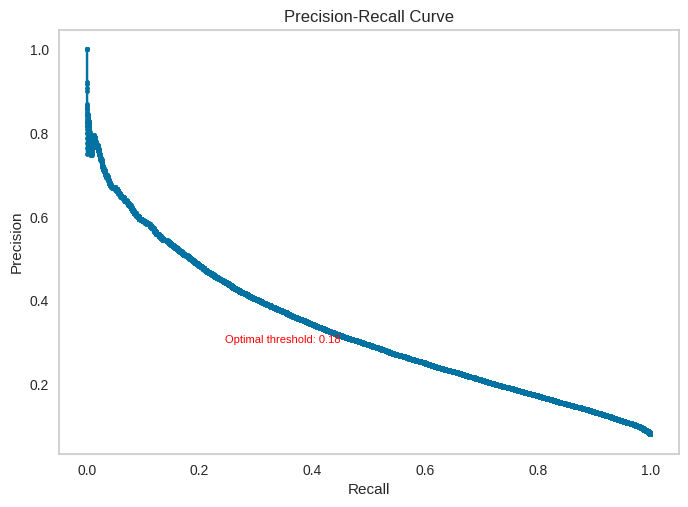

In [157]:
# Evaluate the model
precision, recall, thresholds = precision_recall_curve(y, y_pred)

# Calculate the f-score
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
optimal_threshold= round(thresholds[index], ndigits = 4)
optimal_fscore = round(fscore[index], ndigits = 4)
optimal_recall = round(recall[index], ndigits = 4)
optimal_precision = round(precision[index], ndigits = 4)


# Plot the outcome
plt.plot(recall, precision, marker='.')
plt.scatter(optimal_recall, optimal_precision, c='r', s=10)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.text(optimal_recall, optimal_precision, 
         f'Optimal threshold: {optimal_threshold:.2f}', color='red', fontsize=8,
         verticalalignment='top', horizontalalignment='right')
plt.grid(False)
plt.show()


### From business metric

The aim of the business is to loose as little as possible sources of on defaulters. To some extend the precision will be compromised with recall. Let's check how the business performs at the moment and how much of overall lent amount is lent to defaulters.

In [158]:
total_loss_curr = (application.loc[application['TARGET'] == 1]['AMT_CREDIT'].sum()
                   / application['AMT_CREDIT'].sum())
round(total_loss_curr, 3)

0.075

The bank looses more than 7% of total amount of credit on defaulters. This means that the average of interest rates will be highier than that.

Now let's check how this fraction changes based on the threshold. 

In [159]:
# Adding column with predicted probablities
df_full['PRED_PROB'] = model.predict_proba(X)[:, 1]

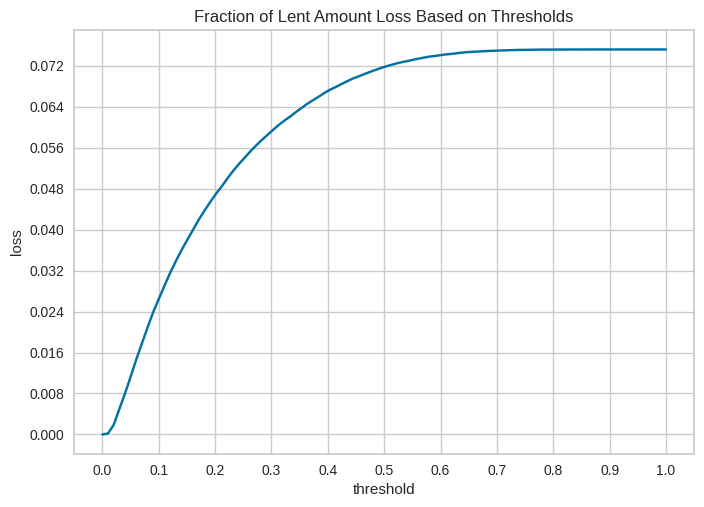

In [174]:
# Calculating total loss for different thresholds
total_loss_model = []
thresholds = np.linspace(0, 1, 100)
for threshold in thresholds:
    loss = (df_full.loc[(df_full['PRED_PROB']<=threshold) & (df_full['TARGET']==1)]['AMT_CREDIT'].sum()
                   / df_full['AMT_CREDIT'].sum())
    total_loss_model.append(loss)

# Plotting the outcome
plt.plot(thresholds, total_loss_model)
plt.xlabel('threshold')
plt.ylabel('loss')
num_ticks = 12
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(num_ticks))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(num_ticks))
plt.grid(True)
plt.title('Fraction of Lent Amount Loss Based on Thresholds');

This graph would be the most important one in estimating what threshold to choose. As we check what are the finanantial losses for 0.08 threshold from roc_auc we see around 2%. Based on recall and precision we would estimate 4% of loss. 

As the current estimation suggest 7.5% we see that the model will always give us a better outcome than the current system. 

Ideally having data on total amount paid we could draw another curve suggesting how much the company looses on highier thresholds.

For now the estimate from recall and precision curve seems to be reasonable to check the confusion matrix.

## Confusion matrix of model with threshold 0.18

              precision    recall  f1-score   support

           0       0.95      0.91      0.93    282686
           1       0.32      0.45      0.37     24825

    accuracy                           0.88    307511
   macro avg       0.63      0.68      0.65    307511
weighted avg       0.90      0.88      0.89    307511



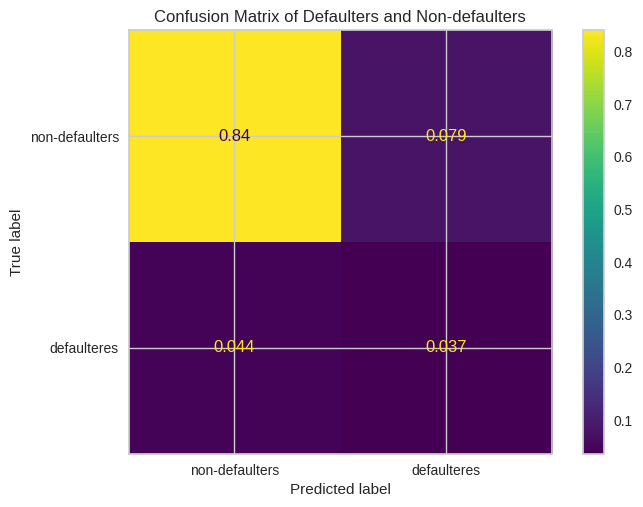

In [175]:
# Convert predicted probabilities to predicted labels based on the threshold
predicted_labels = (y_pred >= 0.18).astype(int)
print(classification_report(y, predicted_labels))
print('='*100)
cm = confusion_matrix(y, predicted_labels, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['non-defaulters', 'defaulteres']) 
disp.plot()
plt.title('Confusion Matrix of Defaulters and Non-defaulters');

From normalized confusion matrix by all entries we see a bit highier recall than precision for defaulters which is desirable. To get highier precision we would need to make threshold highier, to get highier recall we would need to move threshold toward 0. 

## Storing preprocessed complete data for predictions

In [73]:
# Getting data from application train
app = reduce_memory_usage(pd.read_csv('preprocessed_data/selected_application.csv', index_col=0))

# Getting data from other sources
merged = reduce_memory_usage(pd.read_csv('preprocessed_data/merged.csv', index_col=0))

# Columns from training
with open('column_names.txt', 'r') as f:
    col_names = f.read().splitlines()
    
# Merging and filling missing values with 0
all_preprocessed = app.merge(merged, on='SK_ID_CURR', how='left').fillna(0)[col_names + ['TARGET', 'SK_ID_CURR']]

# Storing
all_preprocessed.to_csv('preprocessed_data/modelling_data.csv', index=False)

## Conclusions

* The best performing model had mean ROC_AUC for five stratified folds 0.789 while for test set 0.780. The model overfits slightly what is expected when tuning hyperparameters on folds.
* Optimal threshold can be set based on the roc curve, precision recall curve or business metric. In this example business metric should be calculated comparing the losses from amounts lent to defaulters and losses of not gaining installment rates from potential clients who would repay the loans.
* For the moment being the threshold is set to 0.18 which produces 4% of loss of total lent amount in comparison to 7% which is lost with the current method of predictions.
* The model can be used on clients with no credit history as well as on clients with credit history - the thresholds and business metrics could be calculated for each group of clients.
* To set the true theshold we would need to know loan profitability metric with features to calculate it.